### Import Libraries

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy import stats, optimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Loading Data

In [61]:
df_demo = pd.read_csv("demo.csv")

df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0                         2473 non-null   int64  
 1   table_2019_benchmark  2473 non-null   object 
 2   table_actual          2473 non-null   object 
 3   base_population       2473 non-null   object 
 4   ages                  2473 non-null   object 
 5   ages_min              2473 non-null   int64  
 6   indicator_specific    2473 non-null   object 
 7   indicator_abbr        2473 non-null   object 
 8   indicator_short       2473 non-null   object 
 9   tooth_location        2360 non-null   object 
 10  dentition_set         2473 non-null   object 
 11  category              2473 non-null   object 
 12  subcategory           2473 non-null   object 
 13  years                 2473 non-null   object 
 14  statistic             2473 non-null   object 
 15  estimate_value       

### Data cleaning I

Missing Values from Demo in %:
data_id                 0.0
table_2019_benchmark    0.0
table_actual            0.0
base_population         0.0
ages                    0.0
ages_min                0.0
indicator_specific      0.0
indicator_abbr          0.0
indicator_short         0.0
tooth_location          0.0
dentition_set           0.0
category                0.0
subcategory             0.0
years                   0.0
statistic               0.0
estimate_value          0.0
estimate_SE             0.0
lower_CI                0.0
upper_CI                0.0
dtype: float64


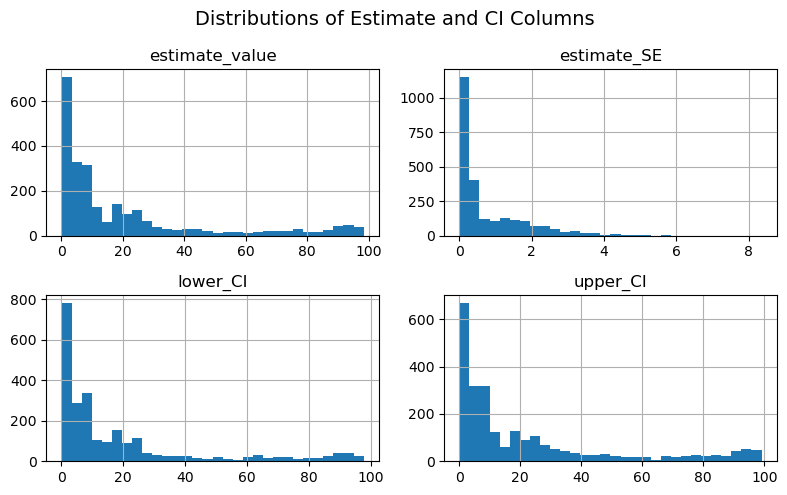

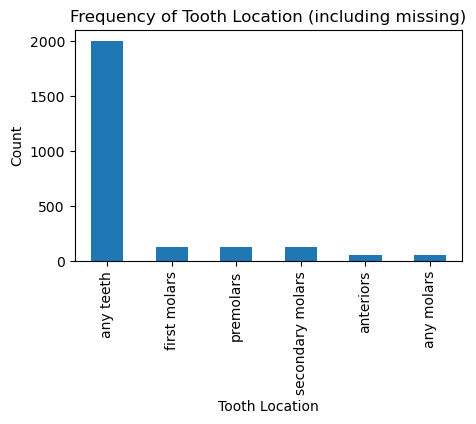

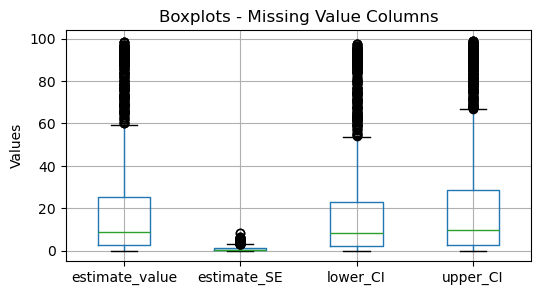

Successfully replaced all missing values
Saved


In [65]:
# Renaming the id column
df_demo.columns.values[0] = "data_id"

# Drop empty unnamed columns
if df_demo.columns[0] == "":
    df_demo = df_demo.drop(columns=[df_demo.columns[0]])

# Checking missing values
missing_demo = (df_demo.isnull().sum() / len(df_demo)) * 100
print("Missing Values from Demo in %:")
print(missing_demo)

# Check distribution of missing value columns
columns = ["estimate_value", "estimate_SE", "lower_CI", "upper_CI"]

df_demo[columns].hist(bins=30, figsize=(8,5))
plt.suptitle("Distributions of Estimate and CI Columns", fontsize=14)
plt.tight_layout()
plt.show()

df_demo["tooth_location"].value_counts(dropna=False).plot.bar(figsize=(5,3))
plt.title("Frequency of Tooth Location (including missing)")
plt.xlabel("Tooth Location")
plt.ylabel("Count")
plt.show()

# Box plot for missing value columns
mv_demo = ["estimate_value", "estimate_SE", "lower_CI", "upper_CI"]

plt.figure(figsize=(6,3))
df_demo[mv_demo].boxplot()
plt.title("Boxplots - Missing Value Columns")
plt.ylabel("Values")
plt.show()

# Replace values of missing values in columns
mv_demo = ["estimate_value", "estimate_SE", "lower_CI", "upper_CI"]
for mv_col in mv_demo:
    df_demo[mv_col] = df_demo[mv_col].fillna(df_demo[mv_col].median())

df_demo["tooth_location"] = df_demo["tooth_location"].fillna(df_demo["tooth_location"].mode()[0])

# Checking
if df_demo.isna().sum().sum() == 0:
    print("Successfully replaced all missing values")
else:
    print("Not successful")

# Save clean df
df_demo.to_csv("demo_clean.csv", index=False)

print("Saved")

### Data cleaning II

In [67]:
# Checking 
print(df_demo["ages"].unique())
print(df_demo["category"].unique())
print(df_demo["subcategory"].unique())
print(df_demo["indicator_short"].unique())
print(df_demo["indicator_specific"].unique())
print(df_demo["years"].unique())
print(df_demo["indicator_abbr"].unique())
print(df_demo["tooth_location"].unique())
print(df_demo["base_population"].unique())

['9-Nov' '75+' '6-Aug' '65-74' '65+' '6-Nov' '50-64' '35-49' '20-64'
 '20-34' '2-May' '16-19' 'Dec-19' 'Dec-15']
['age (years)' 'poverty status (2 levels)' 'all'
 'poverty status (3 levels)' 'race and ethnicity' 'sex'
 'cigarette smoking history' 'education' 'smoking history' 'gender']
['9 -- 11' '75+' '6 -- 8' '< 200% FPL' '≥ 200% FPL' 'total' '< 100% FPL'
 '100% -- 199% FPL' 'Black, non-Hispanic' 'Mexican American'
 'White, non-Hispanic' 'female' 'male' '65 -- 74' 'current smoker'
 'former smoker' 'never smoked' '< high school' '> high school'
 'high school' '50 -- 64' '35 -- 49' '20 -- 34' '16 -- 19' 'Mexican'
 '12 -- 15']
['# DMFT anteriors of those with DMFT'
 '# DMFT any molars of those with DMFT'
 '# DMFT first molars of those with DMFT' '# DT if have DMFT'
 '# FT if have DMFT' '# MT if have DMFT' '# DMFT if have DMFT'
 '# DMFT premolars of those with DMFT ' 'prevalance of caries'
 '# DMFT secondary molars of those with DMFT'
 '# sealed first molars if have sealants'
 '# sealed 

In [69]:
df_demo = pd.read_csv("demo_clean.csv")

# Fix messy data entry

## Ages

df_demo["ages"] = df_demo["ages"].replace({
    "9-Nov": "9–11",
    "6-Aug": "6–8",
    "6-Nov": "6–11",
    "2-May": "2-5",
    "Dec-15": "12-15",
    "Dec-19": "12-19"
    
})

# Save back to CSV (overwrite or new file)
df_demo.to_csv("demo_clean.csv", index=False)

In [71]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   data_id               2473 non-null   int64  
 1   table_2019_benchmark  2473 non-null   object 
 2   table_actual          2473 non-null   object 
 3   base_population       2473 non-null   object 
 4   ages                  2473 non-null   object 
 5   ages_min              2473 non-null   int64  
 6   indicator_specific    2473 non-null   object 
 7   indicator_abbr        2473 non-null   object 
 8   indicator_short       2473 non-null   object 
 9   tooth_location        2473 non-null   object 
 10  dentition_set         2473 non-null   object 
 11  category              2473 non-null   object 
 12  subcategory           2473 non-null   object 
 13  years                 2473 non-null   object 
 14  statistic             2473 non-null   object 
 15  estimate_value       

## EDA 1

### 1. What is the prevalence of edentulism among American adults over the age of 65?

count    55.000000
mean     28.196364
std      10.794406
min       9.300000
25%      18.100000
50%      28.300000
75%      34.675000
max      51.590000
Name: estimate_value, dtype: float64


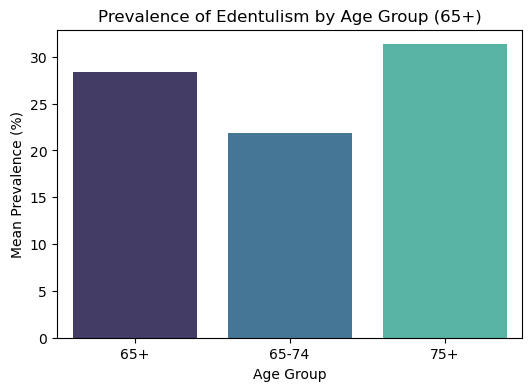

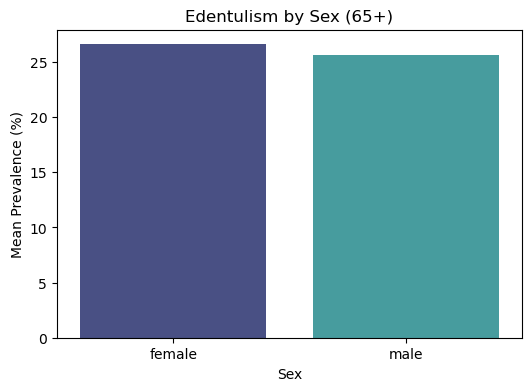

In [73]:
# Filter edentulism for ages ≥ 65
df_edent = df_demo[(df_demo["indicator_abbr"]=="edentulism") & (df_demo["ages_min"]>=65)]

# Summary stats
print(df_edent["estimate_value"].describe())

# Group by age groups (65–74 vs 75+)
edent_age = df_edent.groupby("ages")["estimate_value"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=edent_age, x="ages", y="estimate_value", palette="mako")
plt.title("Prevalence of Edentulism by Age Group (65+)")
plt.ylabel("Mean Prevalence (%)")
plt.xlabel("Age Group")
plt.show()

# Comparison by gender
edent_sex = df_edent[df_edent["category"]=="sex"].groupby("subcategory")["estimate_value"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=edent_sex, x="subcategory", y="estimate_value", palette="mako")
plt.title("Edentulism by Sex (65+)")
plt.ylabel("Mean Prevalence (%)")
plt.xlabel("Sex")
plt.show()

### 2. Are there differences in caries prevalence among young children by race and ethnicity?

           subcategory  estimate_value
0  Black, non-Hispanic       32.982857
1     Mexican American       42.151429
2  White, non-Hispanic       27.012857


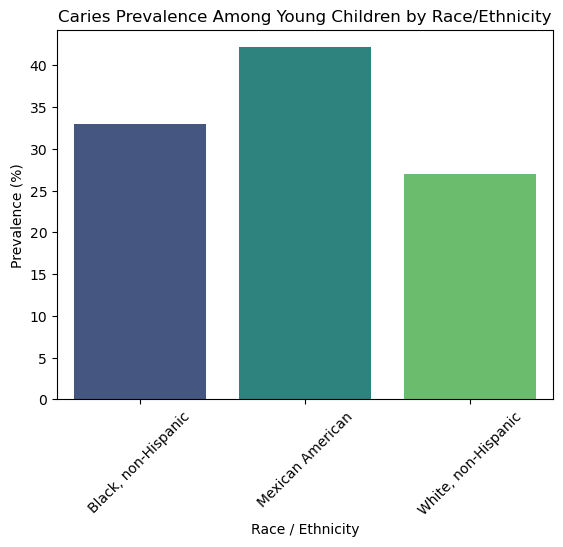

In [75]:
df_children = df_demo[df_demo['ages_min'] <= 11]

caries = df_children[df_children['indicator_abbr'] == 'caries']

caries_race = caries[caries['category'] == 'race and ethnicity']

selected_races = ['Black, non-Hispanic', 'Mexican American', 'White, non-Hispanic', 'Mexican']
caries_race = caries_race[caries_race['subcategory'].isin(selected_races)]

caries_race_summary = caries_race.groupby('subcategory')['estimate_value'].mean().reset_index()

print(caries_race_summary)

# Bar Chart
sns.barplot(data=caries_race_summary, x='subcategory', y='estimate_value', palette="viridis")
plt.title("Caries Prevalence Among Young Children by Race/Ethnicity")
plt.ylabel("Prevalence (%)")
plt.xlabel("Race / Ethnicity")
plt.xticks(rotation=45)
plt.show()

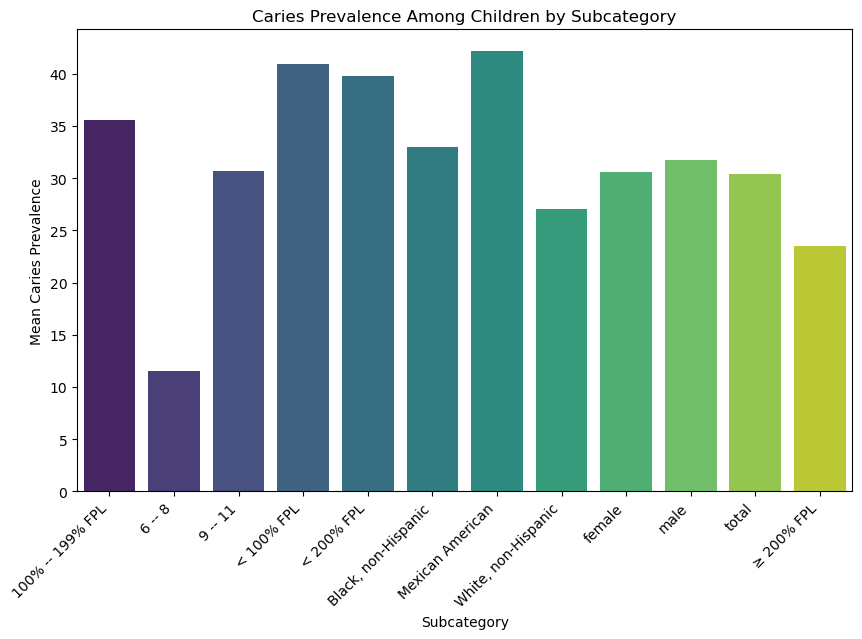

ANOVA F-statistic: 1.72, p-value: 0.0876


In [77]:
# Filter children (ages ≤ 11) and caries indicator
df_children = df_demo[(df_demo["ages_min"] <= 11) & (df_demo["indicator_abbr"] == "caries")]

# Grop by race/ethnicity (subcategory) and calculate mean prevalence
caries_race = df_children.groupby("subcategory")["estimate_value"].mean().reset_index()

# Plot grouped barplot
plt.figure(figsize=(10,6))
sns.barplot(data=caries_race, x="subcategory", y="estimate_value", palette="viridis")
plt.title("Caries Prevalence Among Children by Subcategory")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean Caries Prevalence")
plt.xlabel("Subcategory")
plt.show()

# ANOVA significance test
groups = [g["estimate_value"].dropna().values for _, g in df_children.groupby("subcategory")]
f_stat, p_val = stats.f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")

### 3. Has the mean number of dental sealants per child changed since the 1990s?

Filtered sealants shape: (370, 19)
['# sealed first molars if have sealants'
 '# sealed premolars if have sealants'
 '# sealed secondary molars if have sealants' '# sealants if have sealant'
 'prevalence of sealants']
         years  estimate_value
0  1988 - 1994        6.798364
1  1999 - 2004        9.554615
2  2011 - 2016       11.181538


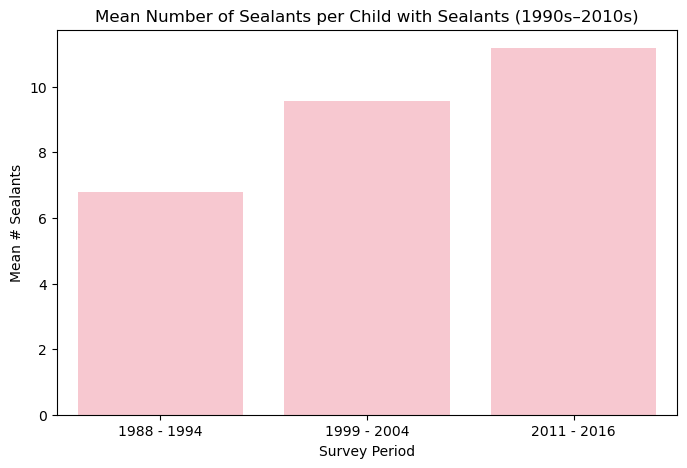

In [79]:
# Filter dataset for sealants 
df_sealants = df_demo[
    (df_demo["indicator_abbr"].isin(["sealants", "sealed"])) &
    (df_demo["indicator_short"].str.contains("sealant"))
].copy()

print("Filtered sealants shape:", df_sealants.shape)
print(df_sealants["indicator_short"].unique())

# Group by survey period
sealant_trend = (
    df_sealants.groupby("years")["estimate_value"]
    .mean()
    .reset_index()
    .sort_values("years")
)

print(sealant_trend)

# Plot trend
plt.figure(figsize=(8,5))
sns.barplot(data=sealant_trend, x="years", y="estimate_value", color="pink")
plt.title("Mean Number of Sealants per Child with Sealants (1990s–2010s)")
plt.xlabel("Survey Period")
plt.ylabel("Mean # Sealants")
plt.show()

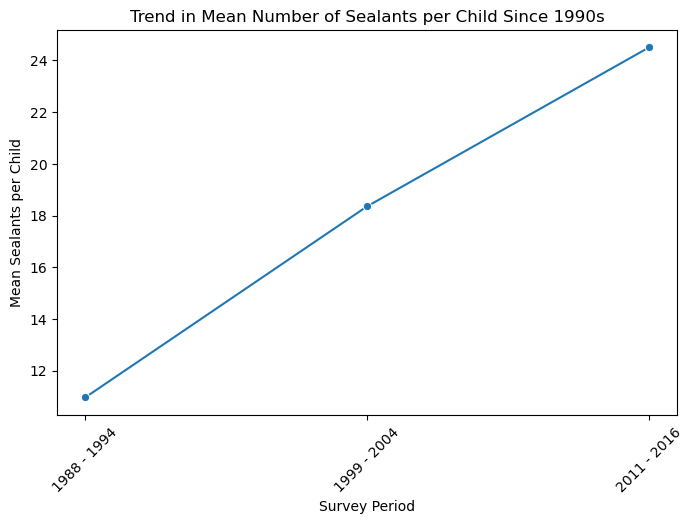

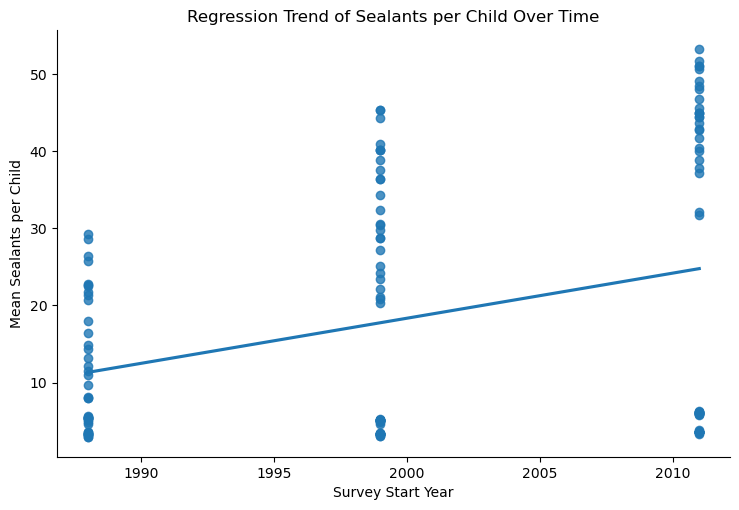

In [81]:
# Filter sealants indicator
df_sealants = df_demo[df_demo["indicator_abbr"]=="sealants"].copy()

# Extract years from the start
df_sealants["year_start"] = df_sealants["years"].str.extract(r"(\d{4})").astype(int)

# Group by survey period and compute mean
sealants_trend = df_sealants.groupby("years")["estimate_value"].mean().reset_index()

# Plot trend line
plt.figure(figsize=(8,5))
sns.lineplot(data=sealants_trend, x="years", y="estimate_value", marker="o")
plt.title("Trend in Mean Number of Sealants per Child Since 1990s")
plt.ylabel("Mean Sealants per Child")
plt.xlabel("Survey Period")
plt.xticks(rotation=45)
plt.show()

# Regression line over continuous years
sns.lmplot(data=df_sealants, x="year_start", y="estimate_value", aspect=1.5, ci=None)
plt.title("Regression Trend of Sealants per Child Over Time")
plt.ylabel("Mean Sealants per Child")
plt.xlabel("Survey Start Year")
plt.show()

### 4. Which types of teeth are most likely to be decayed, missing, or filled?

Filtered DMFT shape: (936, 19)
['any teeth']
  tooth_location indicator_abbr  estimate_value
0      any teeth           DMFT       10.508776
1      any teeth             DT       24.785870
2      any teeth             FT       32.043063
3      any teeth             MT        5.773469


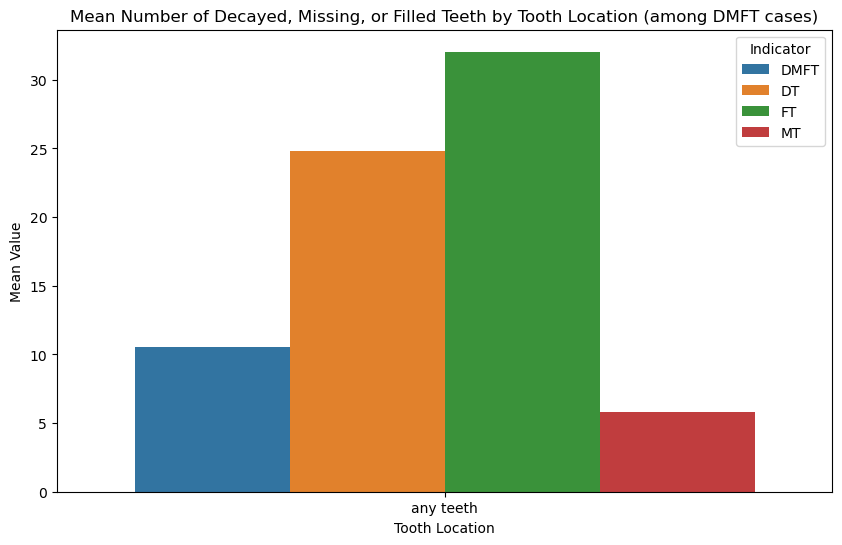

In [83]:
# Filter dataset: only DMFT
df_dmft = df_demo[
    (df_demo["indicator_abbr"].isin(["DT", "FT", "MT", "DMFT"])) &
    (df_demo["indicator_short"].str.contains("if have DMFT"))
].copy()

print("Filtered DMFT shape:", df_dmft.shape)
print(df_dmft["tooth_location"].unique())

# Group by tooth location & indicator type
tooth_summary = (
    df_dmft.groupby(["tooth_location", "indicator_abbr"])["estimate_value"]
    .mean()
    .reset_index()
)

print(tooth_summary)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    data=tooth_summary,
    x="tooth_location",
    y="estimate_value",
    hue="indicator_abbr"
)
plt.title("Mean Number of Decayed, Missing, or Filled Teeth by Tooth Location (among DMFT cases)")
plt.xlabel("Tooth Location")
plt.ylabel("Mean Value")
plt.legend(title="Indicator")
plt.show()

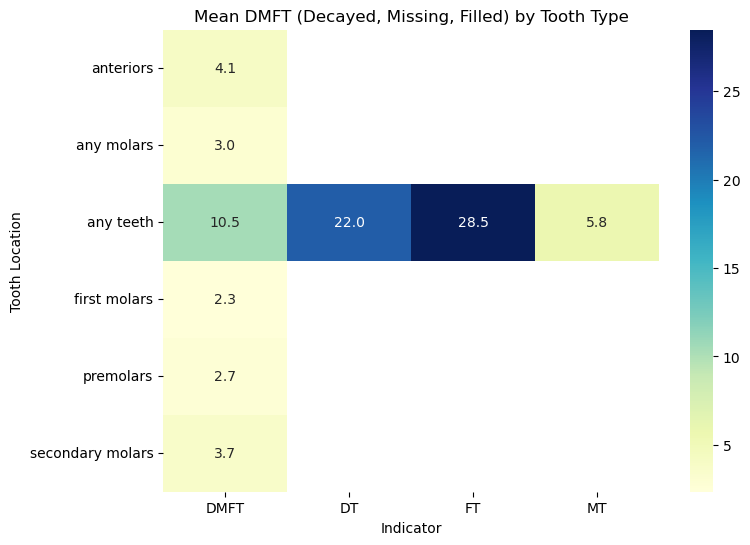

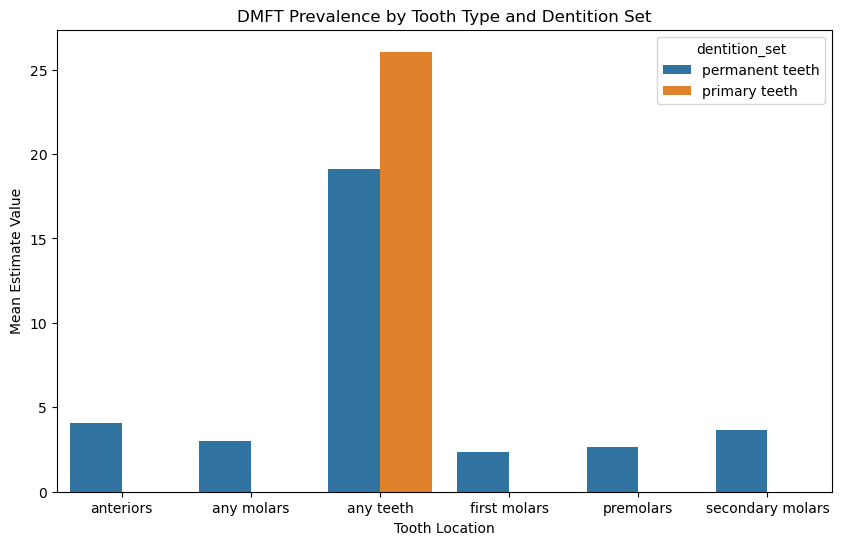

In [85]:
# Filter rows with tooth location info and DMFT indicators
df_teeth = df_demo[df_demo["tooth_location"].notna() & 
                   df_demo["indicator_abbr"].isin(["DMFT","DT","FT","MT"])]

# Aggregate mean estimate_value per tooth_location and indicator
teeth_summary = df_teeth.groupby(["tooth_location","indicator_abbr"])["estimate_value"].mean().reset_index()

# Pivot for heatmap
teeth_pivot = teeth_summary.pivot(index="tooth_location", columns="indicator_abbr", values="estimate_value")

plt.figure(figsize=(8,6))
sns.heatmap(teeth_pivot, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Mean DMFT (Decayed, Missing, Filled) by Tooth Type")
plt.ylabel("Tooth Location")
plt.xlabel("Indicator")
plt.show()

# Comparison between dentition sets
teeth_dentition = df_teeth.groupby(["dentition_set","tooth_location"])["estimate_value"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=teeth_dentition, x="tooth_location", y="estimate_value", hue="dentition_set")
plt.title("DMFT Prevalence by Tooth Type and Dentition Set")
plt.ylabel("Mean Estimate Value")
plt.xlabel("Tooth Location")
plt.show()

### 5. Does the prevalence of caries increased by age?

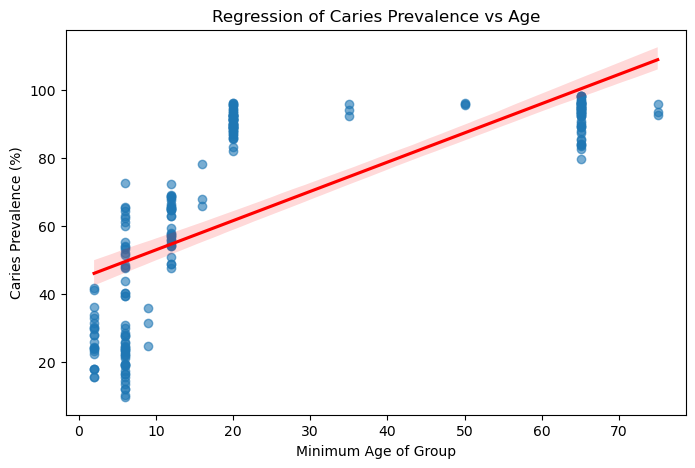

In [87]:
# Filter for caries prevalence
df_caries = df_demo[
    df_demo["indicator_abbr"] == "caries"
].copy()

plt.figure(figsize=(8,5))
sns.regplot(
    data=df_caries,
    x="ages_min",
    y="estimate_value",
    scatter_kws={"alpha":0.6},
    line_kws={"color":"red"}
)
plt.title("Regression of Caries Prevalence vs Age")
plt.xlabel("Minimum Age of Group")
plt.ylabel("Caries Prevalence (%)")
plt.show()

## EDA 2

### 6. Does the prevalence of untreated caries vary with age, and does that relationship differ by poverty status?

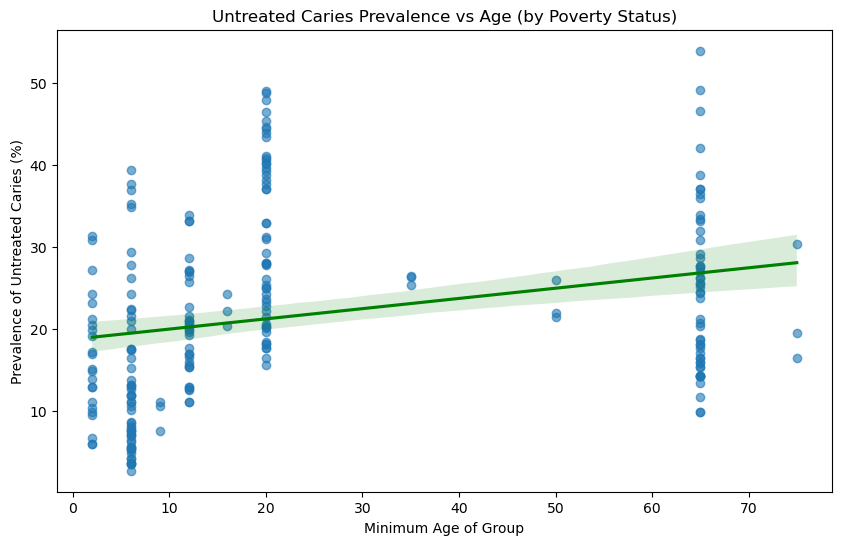

In [89]:
# Filter untreated caries
df_untreated = df_demo[
    df_demo["indicator_abbr"] == "untreated caries"
].copy()

plt.figure(figsize=(10,6))
sns.regplot(
    data=df_untreated,
    x="ages_min",
    y="estimate_value",
    scatter_kws={"alpha":0.6},
    line_kws={"color":"green"}
)
plt.title("Untreated Caries Prevalence vs Age (by Poverty Status)")
plt.xlabel("Minimum Age of Group")
plt.ylabel("Prevalence of Untreated Caries (%)")
plt.show()

### 7. Has the average number of filled teeth changed significantly across survey periods?

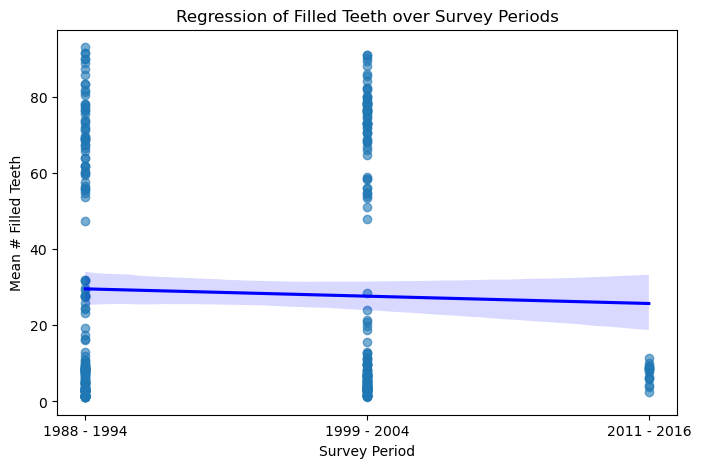

In [91]:
# Filter for FT indicator
df_ft = df_demo[
    df_demo["indicator_abbr"] == "FT"
].copy()

plt.figure(figsize=(8,5))
sns.regplot(
    data=df_ft,
    x=pd.factorize(df_ft["years"])[0],  # convert survey period to numeric order
    y="estimate_value",
    scatter_kws={"alpha":0.6},
    line_kws={"color":"blue"}
)
plt.xticks(
    ticks=range(len(df_ft["years"].unique())),
    labels=sorted(df_ft["years"].unique())
)
plt.title("Regression of Filled Teeth over Survey Periods")
plt.xlabel("Survey Period")
plt.ylabel("Mean # Filled Teeth")
plt.show()

### 8. Which numeric variables in the dataset are strongly correlated with each other?

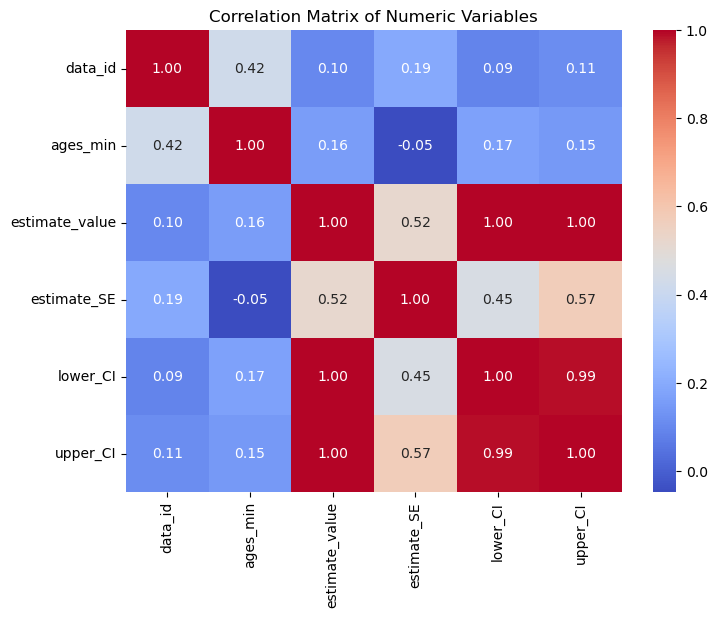

In [93]:
df_num = df_demo.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr = df_num.corr()

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix of Numeric Variables")
plt.show()

### 9. How have oral health indicators changed across the years?

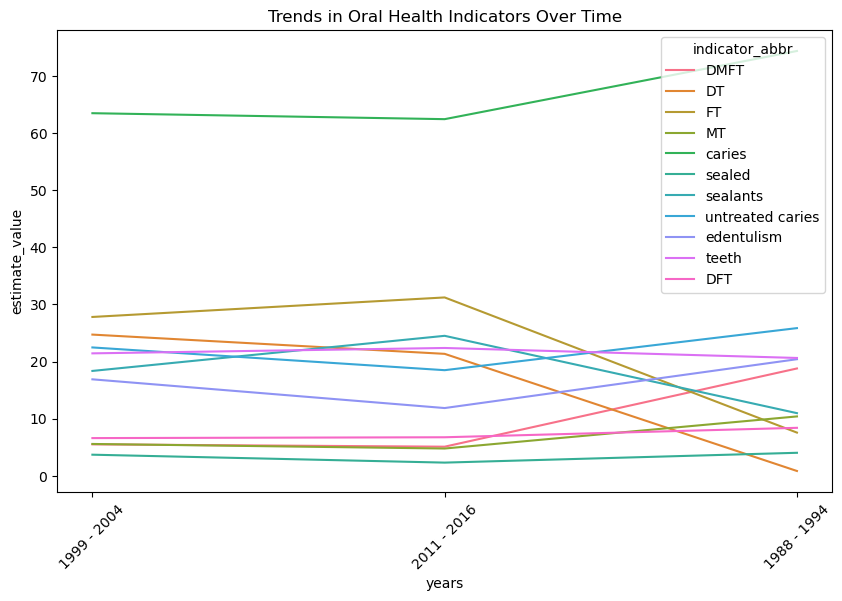

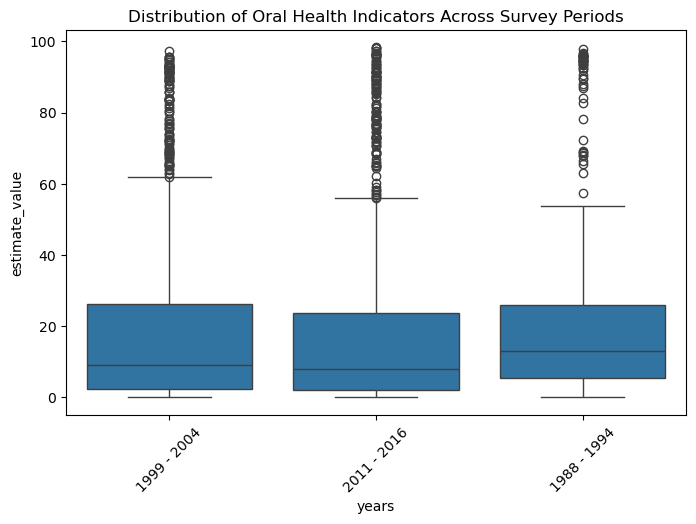

ANOVA (caries across years): F=3.44, p=0.0338
Spearman correlation (caries vs year): rho=-0.17, p=0.0093


In [95]:
# Line plots by indicator
plt.figure(figsize=(10,6))
sns.lineplot(data=df_demo, x="years", y="estimate_value", hue="indicator_abbr", ci=None)
plt.title("Trends in Oral Health Indicators Over Time")
plt.xticks(rotation=45)
plt.show()

# Boxplots by survey periods
plt.figure(figsize=(8,5))
sns.boxplot(data=df_demo, x="years", y="estimate_value")
plt.title("Distribution of Oral Health Indicators Across Survey Periods")
plt.xticks(rotation=45)
plt.show()

# ANOVA across time periods (caries)
caries = df_demo[df_demo["indicator_abbr"]=="caries"]
groups = [g["estimate_value"].dropna() for _, g in caries.groupby("years")]
f_stat, p_val = stats.f_oneway(*groups)
print(f"ANOVA (caries across years): F={f_stat:.2f}, p={p_val:.4f}")

# Spearman rank correlation
caries["year_start"] = caries["years"].str.extract(r"(\d{4})").astype(int)
rho, pval = stats.spearmanr(caries["year_start"], caries["estimate_value"])
print(f"Spearman correlation (caries vs year): rho={rho:.2f}, p={pval:.4f}")

### 10. Is oral health affected by poverty status or education?

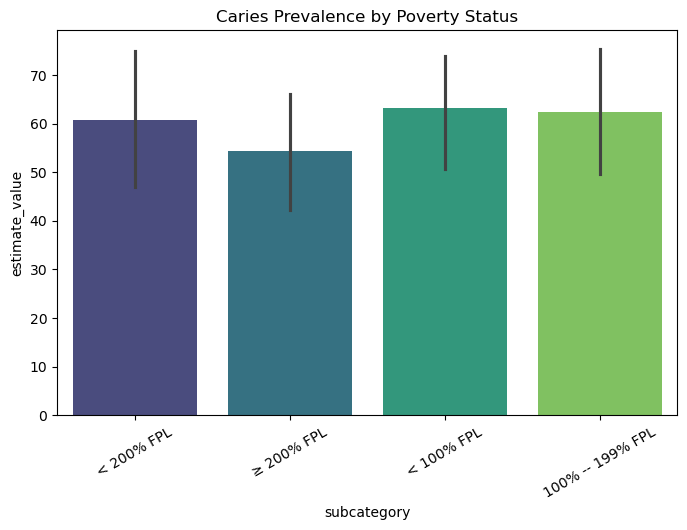

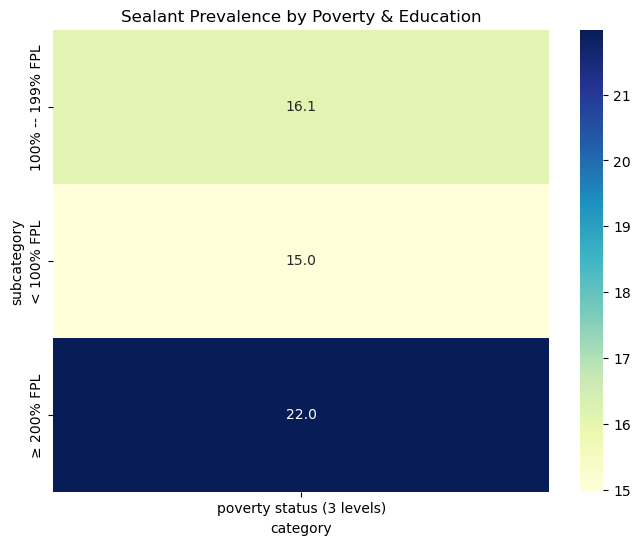

ANOVA (caries by education): F=14.97, p=0.0003


In [97]:
# Poverty status to Caries prevalence
caries_poverty = df_demo[(df_demo["indicator_abbr"]=="caries") & 
                         (df_demo["category"].str.contains("poverty"))]

plt.figure(figsize=(8,5))
sns.barplot(data=caries_poverty, x="subcategory", y="estimate_value", palette="viridis")
plt.title("Caries Prevalence by Poverty Status")
plt.xticks(rotation=30)
plt.show()

# Heatmap: Poverty × Education (for sealants)
sealants_ses = df_demo[(df_demo["indicator_abbr"]=="sealants") & 
                       (df_demo["category"].isin(["poverty status (3 levels)","education"]))]

pivot_ses = sealants_ses.pivot_table(index="subcategory", columns="category", values="estimate_value", aggfunc="mean")

plt.figure(figsize=(8,6))
sns.heatmap(pivot_ses, annot=True, cmap="YlGnBu", fmt=".1f")
plt.title("Sealant Prevalence by Poverty & Education")
plt.show()

# ANOVA on caries by education
caries_edu = df_demo[(df_demo["indicator_abbr"]=="caries") & (df_demo["category"]=="education")]
groups = [g["estimate_value"].dropna() for _, g in caries_edu.groupby("subcategory")]
f_stat, p_val = stats.f_oneway(*groups)
print(f"ANOVA (caries by education): F={f_stat:.2f}, p={p_val:.4f}")

### 11. Are there differences in prevalence between males and females?

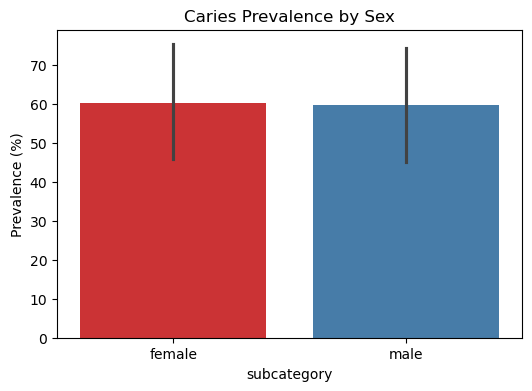

T-test (caries male vs female): t=-0.05, p=0.9566


In [37]:
# Caries by sex
caries_sex = df_demo[(df_demo["indicator_abbr"]=="caries") & (df_demo["category"]=="sex")]

plt.figure(figsize=(6,4))
sns.barplot(data=caries_sex, x="subcategory", y="estimate_value", palette="Set1")
plt.title("Caries Prevalence by Sex")
plt.ylabel("Prevalence (%)")
plt.show()

# t-test male vs female
male_vals = caries_sex[caries_sex["subcategory"]=="male"]["estimate_value"]
female_vals = caries_sex[caries_sex["subcategory"]=="female"]["estimate_value"]
t_stat, p_val = stats.ttest_ind(male_vals.dropna(), female_vals.dropna())
print(f"T-test (caries male vs female): t={t_stat:.2f}, p={p_val:.4f}")

### 12. Is prevalence of caries increased by age?

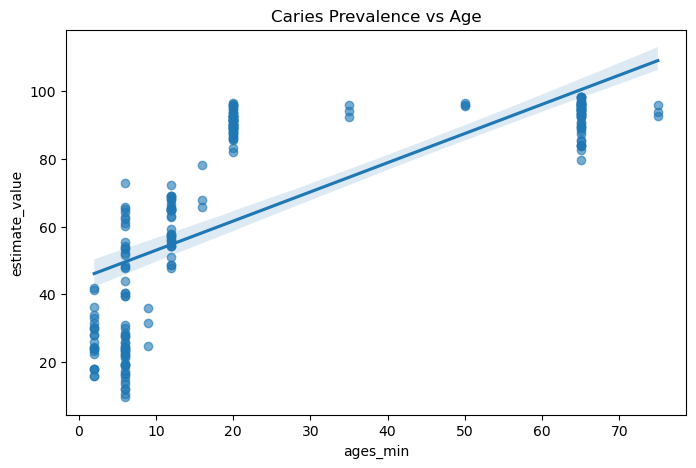

Pearson correlation (age vs caries): r=0.71, p=0.0000


In [99]:
# Scatter with regression line
caries_age = df_demo[df_demo["indicator_abbr"]=="caries"]

plt.figure(figsize=(8,5))
sns.regplot(data=caries_age, x="ages_min", y="estimate_value", scatter_kws={"alpha":0.6})
plt.title("Caries Prevalence vs Age")
plt.show()

# Pearson correlation
r, p = stats.pearsonr(caries_age["ages_min"], caries_age["estimate_value"])
print(f"Pearson correlation (age vs caries): r={r:.2f}, p={p:.4f}")

### 13. How reliable are the edentulism estimates across subgroups, and which groups have the highest uncertainty?

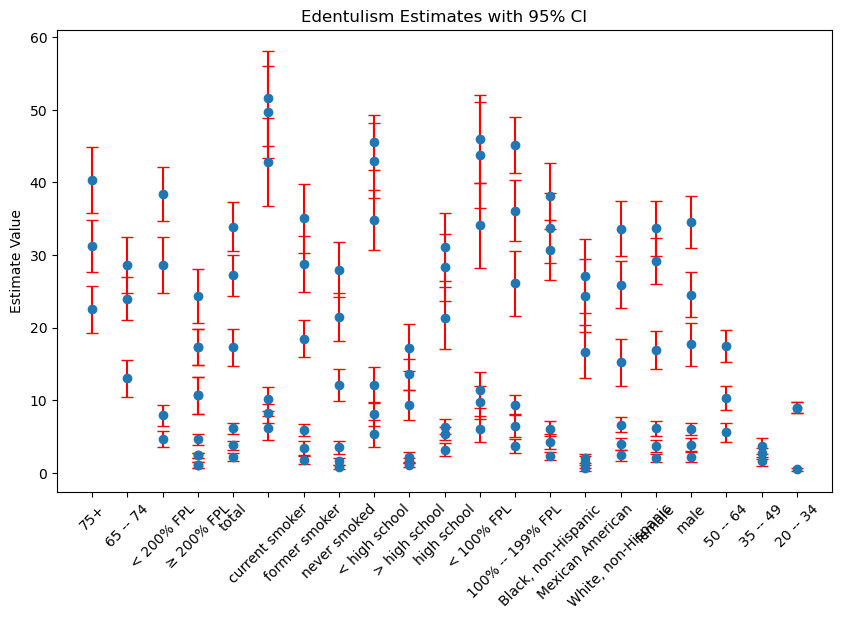

    subcategory  estimate_value  estimate_SE        CV
46          75+           40.28         2.31  0.057349
53          75+           31.20         1.83  0.058654
58          75+           22.50         1.63  0.072444
274    65 -- 74           28.63         1.94  0.067761
279    65 -- 74           24.00         1.53  0.063750


In [101]:
# Chose edentulism with error bars
df_edent_ci = df_demo[df_demo["indicator_abbr"]=="edentulism"]

plt.figure(figsize=(10,6))
plt.errorbar(df_edent_ci["subcategory"], df_edent_ci["estimate_value"], 
             yerr=[df_edent_ci["estimate_value"]-df_edent_ci["lower_CI"], 
                   df_edent_ci["upper_CI"]-df_edent_ci["estimate_value"]], 
             fmt="o", ecolor="red", capsize=4)
plt.xticks(rotation=45)
plt.title("Edentulism Estimates with 95% CI")
plt.ylabel("Estimate Value")
plt.show()

# Coefficient of variation (SE/mean)
df_edent_ci["CV"] = df_edent_ci["estimate_SE"] / df_edent_ci["estimate_value"]
print(df_edent_ci[["subcategory","estimate_value","estimate_SE","CV"]].head())

### 14. Which oral health indicators are most strongly correlated with each other across groups?

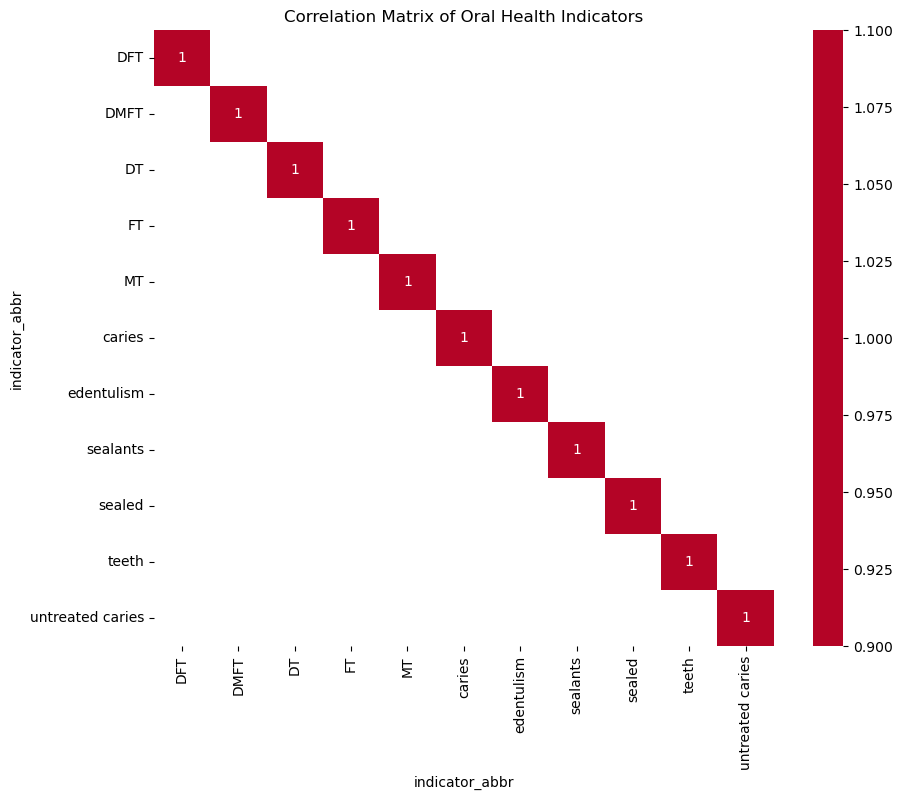

In [103]:
# Correlation across indicators (mean by group)
indicator_corr = df_demo.pivot_table(index="data_id", columns="indicator_abbr", values="estimate_value", aggfunc="mean")

plt.figure(figsize=(10,8))
sns.heatmap(indicator_corr.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Oral Health Indicators")
plt.show()

### 15. How does the prevalence of dental caries differ across socioeconomic groups and what is the disparity between the lowest and highest SES groups?

SES summary (example):
                     category    subcategory  estimate_value
0                  education  < high school       87.636667
1                  education  > high school       95.305000
2                  education    high school       94.238333
3  poverty status (2 levels)     < 200% FPL       60.700000
4  poverty status (2 levels)     ≥ 200% FPL       51.775000
                    category         lowest        highest   low_mean  \
0  poverty status (2 levels)     ≥ 200% FPL     < 200% FPL  51.775000   
1  poverty status (3 levels)     ≥ 200% FPL     < 100% FPL  56.379375   
2                  education  < high school  > high school  87.636667   

   high_mean        PR        RD  
0   60.70000  1.172380  8.925000  
1   63.18375  1.120689  6.804375  
2   95.30500  1.087501  7.668333  


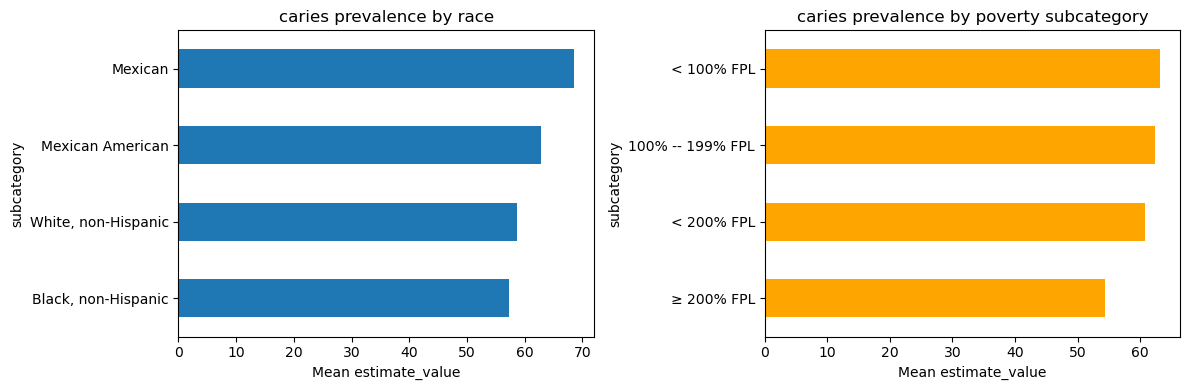

In [107]:
# Indicator chosen to compare oral issues
indicator = "caries"  
df_ind = df_demo[df_demo["indicator_abbr"] == indicator].copy()

# Keep only SES-related rows
ses_mask = df_ind["category"].str.contains("poverty|education", case=False, na=False)
df_ses = df_ind[ses_mask].copy()

# Pivot mean estimate_value by subcategory (SES) x subgroup 
ses_summary = df_ses.groupby(["category", "subcategory"])["estimate_value"].mean().reset_index()
print("SES summary (example):\n", ses_summary.head())

# Prevalence ratio and difference: compare lowest vs highest SES within same category
def compute_disparities(df, category_name):
    subset = df[(df["category"]==category_name)].dropna(subset=["estimate_value"])
    if subset.empty: 
        return None
    # sort subcategories by mean prevalence (low->high)
    means = subset.groupby("subcategory")["estimate_value"].mean().sort_values()
    low = means.iloc[0]; high = means.iloc[-1]
    pr = high / low if low != 0 else np.nan
    rd = high - low
    return {"category": category_name, "lowest": means.index[0], "highest": means.index[-1],
            "low_mean": low, "high_mean": high, "PR": pr, "RD": rd}

disparities = []
for cat in df_ses["category"].unique():
    res = compute_disparities(df_ses, cat)
    if res:
        disparities.append(res)
disparities_df = pd.DataFrame(disparities)
print(disparities_df)

# Heatmap of disparities across race × income × sex example:
# Rows = race, cols = poverty subcategory, values = mean prevalence
race_df = df_ind[df_ind["category"].str.contains("race", case=False, na=False)]
poverty_df = df_ind[df_ind["category"].str.contains("poverty", case=False, na=False)]
mean_by_race = race_df.groupby("subcategory")["estimate_value"].mean()
mean_by_poverty = poverty_df.groupby("subcategory")["estimate_value"].mean()

# Plot side-by-side bars
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
mean_by_race.sort_values().plot(kind="barh")
plt.title(f"{indicator} prevalence by race")
plt.xlabel("Mean estimate_value")
plt.subplot(1,2,2)
mean_by_poverty.sort_values().plot(kind="barh", color="orange")
plt.title(f"{indicator} prevalence by poverty subcategory")
plt.xlabel("Mean estimate_value")
plt.tight_layout()
plt.show()

### 16. Is there evidence of significant differences in caries prevalence trends across racial groups over time?

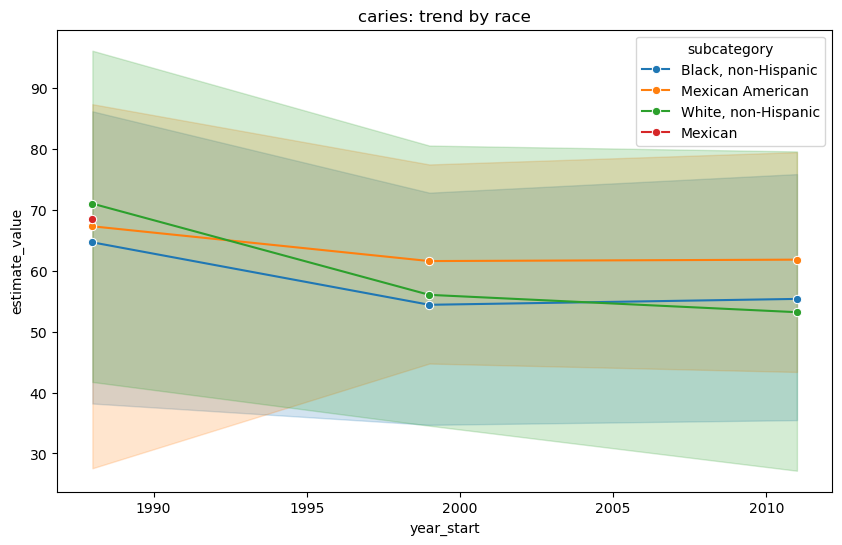

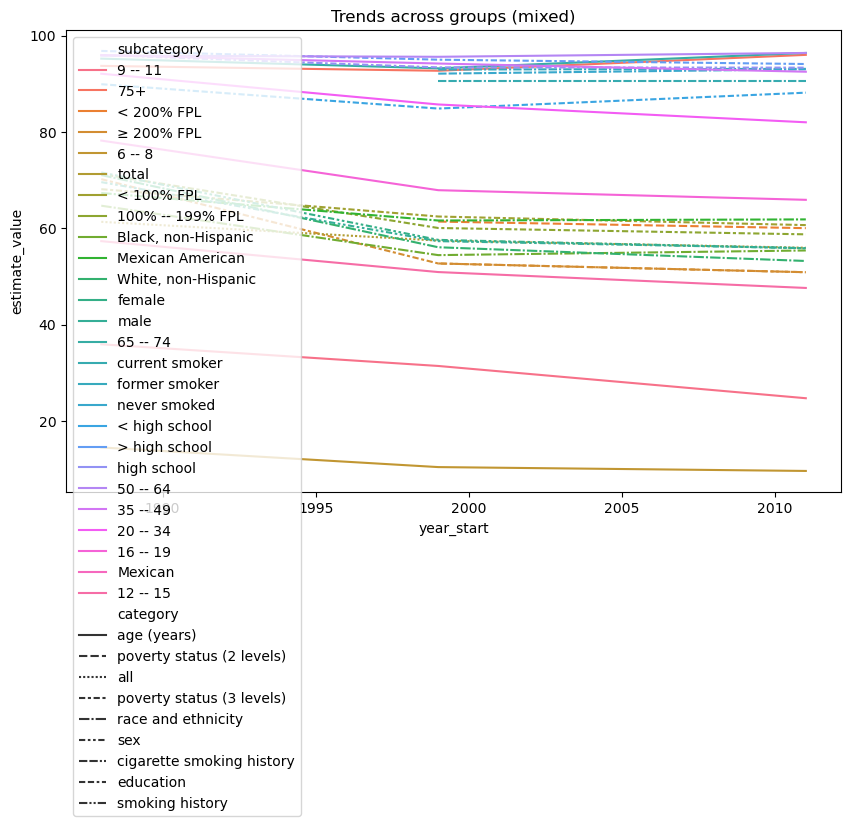

                            OLS Regression Results                            
Dep. Variable:         estimate_value   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                 -0.183
Method:                 Least Squares   F-statistic:                    0.1921
Date:                Mon, 29 Sep 2025   Prob (F-statistic):              0.994
Time:                        15:57:44   Log-Likelihood:                -225.30
No. Observations:                  48   AIC:                             470.6
Df Residuals:                      38   BIC:                             489.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [109]:
# Trend lines by subgroup (race, income, education)
indicator = "caries"   # or change
df_tr = df_demo[df_demo["indicator_abbr"]==indicator].dropna(subset=["estimate_value","years"])

# Extract numeric year (start)
df_tr["year_start"] = df_tr["years"].str.extract(r"(\d{4})").astype(float)

# Trend lines by race
race_mask = df_tr["category"].str.contains("race", case=False, na=False)
if race_mask.any():
    df_race = df_tr[race_mask].copy()
    plt.figure(figsize=(10,6))
    sns.lineplot(data=df_race, x="year_start", y="estimate_value", hue="subcategory", marker="o")
    plt.title(f"{indicator}: trend by race")
    plt.show()

# Faceted line plot by poverty
plt.figure(figsize=(10,6))
sns.lineplot(data=df_tr, x="year_start", y="estimate_value", hue="subcategory", style="category", ci=None)
plt.title("Trends across groups (mixed)")
plt.show()

# Two-way ANOVA example (time period * group)
# Use categorical and race as subcategory
df_anova = df_tr[df_tr["category"].str.contains("race", case=False, na=False)].dropna(subset=["subcategory"])
top_groups = df_anova["subcategory"].value_counts().nlargest(4).index
df_anova = df_anova[df_anova["subcategory"].isin(top_groups)]

# Fit two-way ANOVA
model = smf.ols('estimate_value ~ C(years) + C(subcategory) + C(years):C(subcategory)', data=df_anova).fit()
print(model.summary())
anova_table = sm.stats.anova_lm(model, typ=2)
print("Two-way ANOVA table:\n", anova_table)

# Simple Regression
df_piece = df_tr.groupby("year_start")["estimate_value"].mean().reset_index().dropna()
x = df_piece["year_start"].values
y = df_piece["estimate_value"].values

def piecewise_linear(x, x0, k1, b1, k2, b2):
    return np.where(x < x0, k1*x + b1, k2*x + b2)

# initial guess
p0 = [np.median(x), 0, 0, 0, 0]
try:
    popt, _ = optimize.curve_fit(piecewise_linear, x, y, p0)
    x0, k1, b1, k2, b2 = popt
    print(f"Breakpoint at year ~ {x0:.1f}")
    plt.figure(figsize=(8,5))
    plt.scatter(x, y)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, piecewise_linear(xs, *popt), color="red")
    plt.title("Piecewise linear fit")
    plt.xlabel("Year")
    plt.ylabel("Estimate")
    plt.show()
except Exception as e:
    print("Piecewise fit failed or not enough points:", e)

### 17. Which factors are most important in predicting whether a group has high prevalence of untreated caries?

ROC AUC: 0.8790849673202614
              precision    recall  f1-score   support

           0       0.76      0.85      0.81        34
           1       0.84      0.75      0.79        36

    accuracy                           0.80        70
   macro avg       0.80      0.80      0.80        70
weighted avg       0.80      0.80      0.80        70



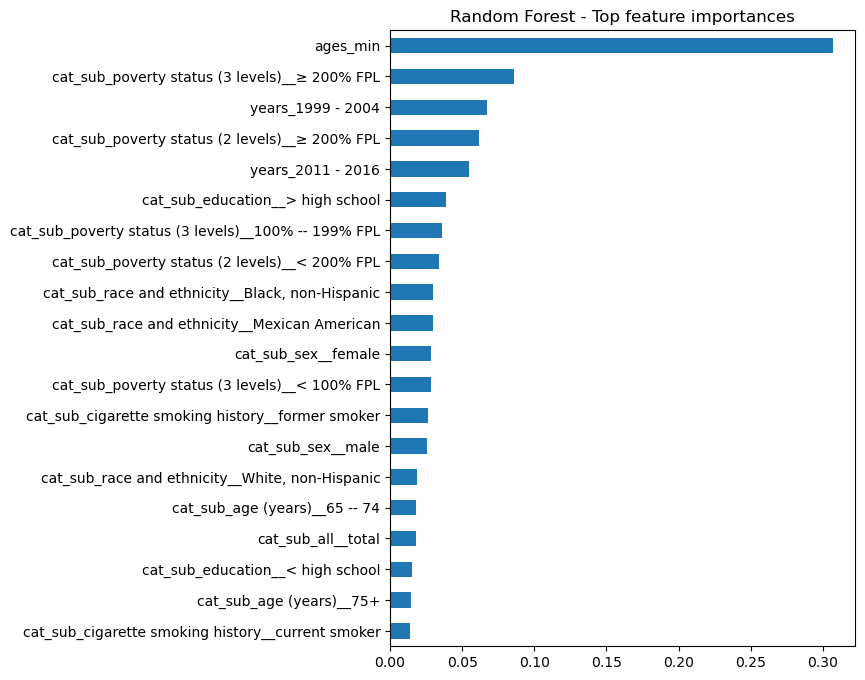

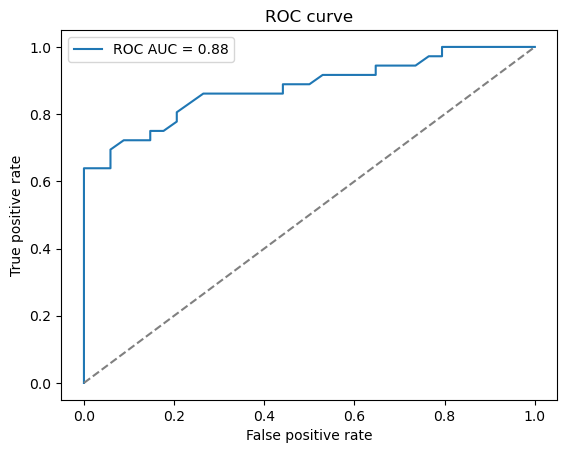

In [111]:
# Choose outcome (binary)
indicator = "untreated caries"
df_pred = df_demo[df_demo["indicator_abbr"]==indicator].copy().dropna(subset=["estimate_value"])

# create binary target: e.g., > median prevalence considered 'case'
df_pred["target"] = (df_pred["estimate_value"] >= df_pred["estimate_value"].median()).astype(int)

# Select features: ages_min, category/subcategory encodings, years
features = ["ages_min", "years", "subcategory", "category", "dentition_set"]
df_pred = df_pred[features + ["target"]].dropna()

# Simplify: one-hot encode 'category'+'subcategory' combined
df_pred["cat_sub"] = df_pred["category"].astype(str) + "__" + df_pred["subcategory"].astype(str)
X = pd.get_dummies(df_pred[["ages_min","years","cat_sub"]].fillna("NA"), drop_first=True)
y = df_pred["target"].values

# Train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_proba = rf.predict_proba(X_test)[:,1]
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, rf.predict(X_test)))

# Feature importance (show top 20)
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(6,8))
fi.plot(kind="barh")
plt.title("Random Forest - Top feature importances")
plt.gca().invert_yaxis()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test,y_proba):.2f}")
plt.plot([0,1],[0,1],"--", color="grey")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()
plt.show()

### 18. Which model explains the relationship between age and edentulism prevalence?

Linear AIC/BIC: 475.1092399792353 480.56401561666
Exponential AIC/BIC: 473.5847412136826 479.0395168511073


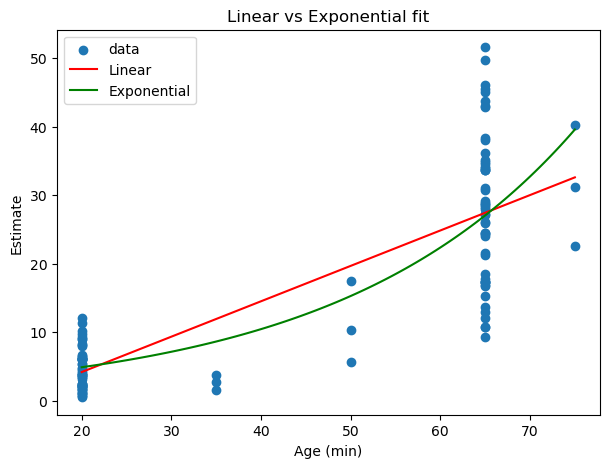

In [113]:
# Select indicator that measures tooth loss or edentulism as function of age
indicator = "edentulism"
df_age = df_demo[(df_demo["indicator_abbr"]==indicator)].dropna(subset=["estimate_value","ages_min"])

x = df_age["ages_min"].astype(float).values
y = df_age["estimate_value"].astype(float).values

# Linear fit
lin_coef = np.polyfit(x, y, 1)
y_lin = np.polyval(lin_coef, x)
rss_lin = np.sum((y - y_lin)**2)
n = len(y); k_lin = 2
aic_lin = n * np.log(rss_lin / n) + 2*k_lin
bic_lin = n * np.log(rss_lin / n) + k_lin * np.log(n)

# Exponential fit: y = a * exp(b*x)
def exp_func(x, a, b):
    return a * np.exp(b * x)

# To make exponential fit stable, scale age or center it
x_scaled = x - x.mean()
try:
    popt, _ = optimize.curve_fit(exp_func, x_scaled, y, p0=(0.01, 0.01), maxfev=10000)
    y_exp = exp_func(x_scaled, *popt)
    rss_exp = np.sum((y - y_exp)**2)
    k_exp = 2
    aic_exp = n * np.log(rss_exp / n) + 2*k_exp
    bic_exp = n * np.log(rss_exp / n) + k_exp * np.log(n)
    print("Linear AIC/BIC:", aic_lin, bic_lin)
    print("Exponential AIC/BIC:", aic_exp, bic_exp)
    plt.figure(figsize=(7,5))
    plt.scatter(x,y, label="data")
    xs = np.linspace(x.min(), x.max(),100)
    plt.plot(xs, np.polyval(lin_coef, xs), label="Linear", color="red")
    plt.plot(xs, exp_func(xs - x.mean(), *popt), label="Exponential", color="green")
    plt.xlabel("Age (min)")
    plt.ylabel("Estimate")
    plt.legend()
    plt.title("Linear vs Exponential fit")
    plt.show()
except Exception as e:
    print("Exponential fit failed:", e)
    plt.scatter(x,y); plt.plot(np.sort(x), np.polyval(lin_coef, np.sort(x)), color="red"); plt.show()

### 19. Which estimates are most precise or uncertain? 
#### - Checking reliability

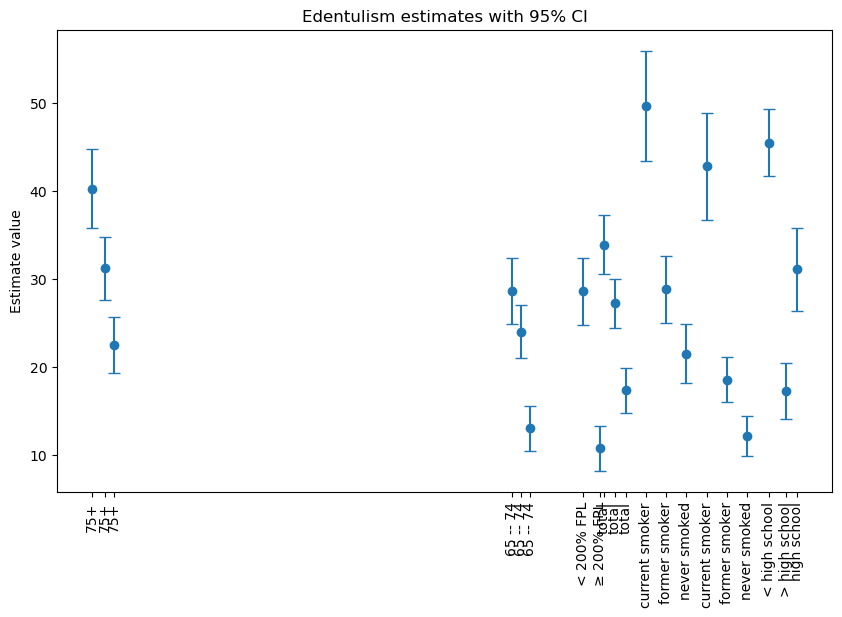

           subcategory  estimate_value  estimate_SE        CV
1758          20 -- 34            9.00         0.29  0.032222
1752          20 -- 34            9.00         0.29  0.032222
414      < high school           45.51         1.96  0.043067
544   100% -- 199% FPL           45.12         1.97  0.043661
509         < 200% FPL           38.40         1.91  0.049740
Unreliable counts: 0
        subcategory  inv_var_mean
0  100% -- 199% FPL      7.895941
1          20 -- 34      2.660841
2          35 -- 49      2.334838
3          50 -- 64      9.252276
4          65 -- 74     19.890822


In [115]:
# Example: edentulism estimates with CI
df_ci = df_demo[df_demo["indicator_abbr"]=="edentulism"].dropna(subset=["estimate_value","lower_CI","upper_CI","estimate_SE"])

# Errorbar plot for a subset (e.g., first 20 rows)
sample = df_ci.head(20)
lower_err = sample["estimate_value"] - sample["lower_CI"]
upper_err = sample["upper_CI"] - sample["estimate_value"]
plt.figure(figsize=(10,6))
plt.errorbar(sample.index, sample["estimate_value"], yerr=[lower_err, upper_err], fmt='o', capsize=4)
plt.xticks(sample.index, sample["subcategory"], rotation=90)
plt.title("Edentulism estimates with 95% CI")
plt.ylabel("Estimate value")
plt.show()

# Coefficient of Variation (CV = SE / mean)
df_ci["CV"] = df_ci["estimate_SE"] / df_ci["estimate_value"].replace(0, np.nan)
print(df_ci[["subcategory","estimate_value","estimate_SE","CV"]].sort_values("CV").head())

# Flag unreliable estimates (CV > 0.3)
unreliable = df_ci[df_ci["CV"] > 0.3]
print("Unreliable counts:", len(unreliable))

# Inverse-variance weighted mean by subgroup example (weights = 1/SE^2)
def inv_var_mean(df, value_col="estimate_value", se_col="estimate_SE"):
    w = 1.0 / (df[se_col]**2)
    return (df[value_col] * w).sum() / w.sum()

weighted_by_group = df_ci.groupby("subcategory").apply(lambda g: inv_var_mean(g)).reset_index().rename(columns={0:"inv_var_mean"})
print(weighted_by_group.head())

### 20. Which indicators are related, and are there distinct subgroup profiles?

Gini: 0.16303233333922607 Theil: 0.05533951898805328
          indicator      gini     theil  n_groups
1        edentulism  0.249006  0.103488        21
3  untreated caries  0.196786  0.067119        25
0            caries  0.163304  0.054070        26
2          sealants  0.098940  0.015286        14


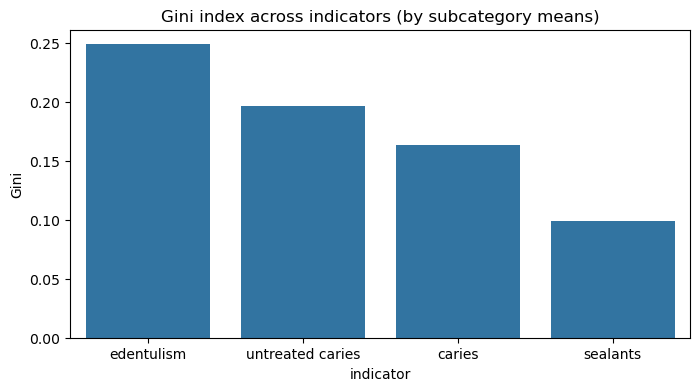

In [117]:
# Functions for Gini and Theil
def gini(array):
    """Compute Gini coefficient of array (non-negative)."""
    array = np.array(array).flatten()
    if np.any(array < 0):
        array = array - array.min()  # shift
    n = len(array)
    if n == 0:
        return np.nan
    array_sorted = np.sort(array)
    index = np.arange(1, n+1)
    return (2.0 * np.sum(index * array_sorted) / (n * array_sorted.sum())) - (n+1)/n

def theil(array):
    x = np.array(array).flatten()
    x = x[x > 0]
    if len(x)==0:
        return np.nan
    mean = x.mean()
    return np.sum((x/mean) * np.log(x/mean)) / len(x)

# Computing inequality across poverty subcategories for edentulism
ind = "edentulism"
df_eq = df_demo[df_demo["indicator_abbr"]==ind].dropna(subset=["estimate_value"])
# choose a grouping (poverty)
group_df = df_eq[df_eq["category"].str.contains("poverty", case=False, na=False)]
vals = group_df.groupby("subcategory")["estimate_value"].mean().dropna().values
print("Gini:", gini(vals), "Theil:", theil(vals))

# Compute inequality score across multiple indicators (loop)
indicators = ["caries", "edentulism", "sealants", "untreated caries"]
ineq_list = []
for ind in indicators:
    d = df_demo[df_demo["indicator_abbr"]==ind]
    g = d.groupby("subcategory")["estimate_value"].mean().dropna().values
    ineq_list.append({"indicator":ind, "gini": gini(g), "theil": theil(g), "n_groups":len(g)})
ineq_df = pd.DataFrame(ineq_list)
print(ineq_df.sort_values("gini", ascending=False))

# Plot inequality scores
plt.figure(figsize=(8,4))
sns.barplot(data=ineq_df.sort_values("gini", ascending=False), x="indicator", y="gini")
plt.title("Gini index across indicators (by subcategory means)")
plt.ylabel("Gini")
plt.show()